In [1]:
# Theoretical limit with multi-agents and multi-actions on a/b side
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import fsolve
from itertools import product
from scipy.special import comb

In [2]:
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})
DELTA = 0.0

n_agents = 2
tick_num = 4

sig = 0.1
inven_factor = 0.1

space = np.linspace(0.1, 0.5, tick_num)
weights = np.linspace(0.0, 0.1, tick_num)

# space = np.zeros(tick_num)
# space[0] = 0.5
# space[1] = 0.9
# weights = np.zeros(tick_num)
# weights[0] = 0.02
# weights[1] = 0.04

def margin(action):
    price = space[action]
    kernel = np.sum(weights[action])
    kernel = kernel / sig / n_agents
    arrival_prob = np.exp(-kernel)
    winner = np.where(price == price.min())
    return arrival_prob, winner, price.min() / len(winner[0])


def expected_reward(ask_action, bid_action):
    # the first item in all actions is the player
    ask_prob, ask_winner, ask_reward = margin(ask_action)
    bid_prob, bid_winner, bid_reward = margin(bid_action)

    total_reward = np.zeros(n_agents)
    total_reward[ask_winner] += ask_reward * ask_prob
    total_reward[bid_winner] += bid_reward * bid_prob

    inven_risk = np.zeros(n_agents)
    # Case 1: both ask and bid orders arrived
    inventory = np.zeros(n_agents)
    inventory[ask_winner] -= 1 / len(ask_winner[0])
    inventory[bid_winner] += 1 / len(bid_winner[0])
    inven_risk += inven_factor * ask_prob * bid_prob * inventory ** 2

    # Case 2: only ask order arrived
    inventory = np.zeros(n_agents)
    inventory[ask_winner] -= 1 / len(ask_winner[0])
    # inventory[bid_winner] += 1 / len(bid_winner[0])
    inven_risk += inven_factor * ask_prob * (1 - bid_prob) * inventory ** 2

    # Case 3: only bid order arrived
    inventory = np.zeros(n_agents)
    # inventory[ask_winner] -= 1 / len(ask_winner[0])
    inventory[bid_winner] += 1 / len(bid_winner[0])
    inven_risk += inven_factor * (1 - ask_prob) * bid_prob * inventory ** 2

    total_reward -= inven_risk

    return total_reward[0]


def Boltz(x):
    #     prob = x/np.sum(x)
    prob = np.exp(x / temper)
    prob = prob / np.sum(prob)
    #     prob = np.ones(tick_num**2)/tick_num**2
    return prob


def gen_act(C, ask_tick, bid_tick):
    ind = np.cumsum(C)
    action = np.zeros(n_agents)
    for k in reversed(range(len(ind))):
        action[1:ind[k] + 1] = k
    action[0] = ask_tick * tick_num + bid_tick
    return action

# Enumerate all possible actions for other agents beside self
act_count = [np.array(val) for val in product(range(n_agents), repeat=tick_num ** 2) if sum(val) == (n_agents - 1)]

def F(Q):
    # Q is the Q function with shape tick_num**2
    Prob = Boltz(Q)
    # reward multiplied by multinomial probabilities
    ER = np.zeros(tick_num ** 2)
    for ask_tick in range(tick_num):
        for bid_tick in range(tick_num):
            # Loop over actions of other agents
            for k in range(len(act_count)):
                C = act_count[k]
                # temp is multinomial probability
                temp = comb(n_agents - 1, C[0]) * np.power(Prob[0], C[0])
                for ab in range(1, tick_num ** 2):
                    temp = temp * comb(n_agents - 1 - np.sum(C[:ab]), C[ab]) * np.power(Prob[ab], C[ab])
                action = gen_act(C, ask_tick, bid_tick)
                ask_action = (action // tick_num).astype(int)
                bid_action = (action % tick_num).astype(int)
                ER[ask_tick * tick_num + bid_tick] += temp * expected_reward(ask_action, bid_action)
    return ER + DELTA * np.max(Q) - Q

In [3]:
kernel = weights / sig
np.exp(-kernel)

array([ 1.0000,  0.7165,  0.5134,  0.3679])

In [4]:
np.exp(-1)

0.36787944117144233

In [5]:
weights

array([ 0.0000,  0.0333,  0.0667,  0.1000])

In [6]:
space

array([ 0.1000,  0.2333,  0.3667,  0.5000])

In [7]:
temper = 0.1
init = np.zeros(tick_num**2)
init[0] = 0.8
sol = fsolve(F, init)
print('Temperature', temper)
print('Q-values q*', sol)
print('Probability p*', Boltz(sol))
print('Residuals of contraction map', F(sol))

Temperature 0.1
Q-values q* [ 0.1063  0.1088  0.0665  0.0256  0.1088  0.1333  0.1049  0.0706  0.0665
  0.1049  0.0859  0.0565  0.0256  0.0706  0.0565  0.0297]
Probability p* [ 0.0803  0.0823  0.0539  0.0358  0.0823  0.1051  0.0791  0.0562  0.0539
  0.0791  0.0654  0.0488  0.0358  0.0562  0.0488  0.0373]
Residuals of contraction map [-0.0000 -0.0000  0.0000  0.0000 -0.0000 -0.0000 -0.0000 -0.0000  0.0000
 -0.0000  0.0000  0.0000  0.0000 -0.0000  0.0000  0.0000]


In [8]:
R = np.zeros((tick_num**2, tick_num**2))

for i in range(tick_num**2):
    for j in range(tick_num**2):
        ask_action = np.zeros(n_agents)
        bid_action = np.zeros(n_agents)
        ask_action[0] = (i // tick_num)
        bid_action[0] = (i % tick_num)
        ask_action[1] = (j // tick_num)
        bid_action[1] = (j % tick_num)
        ask_action = ask_action.astype(int)
        bid_action = bid_action.astype(int)
        R[i, j] = expected_reward(ask_action, bid_action)

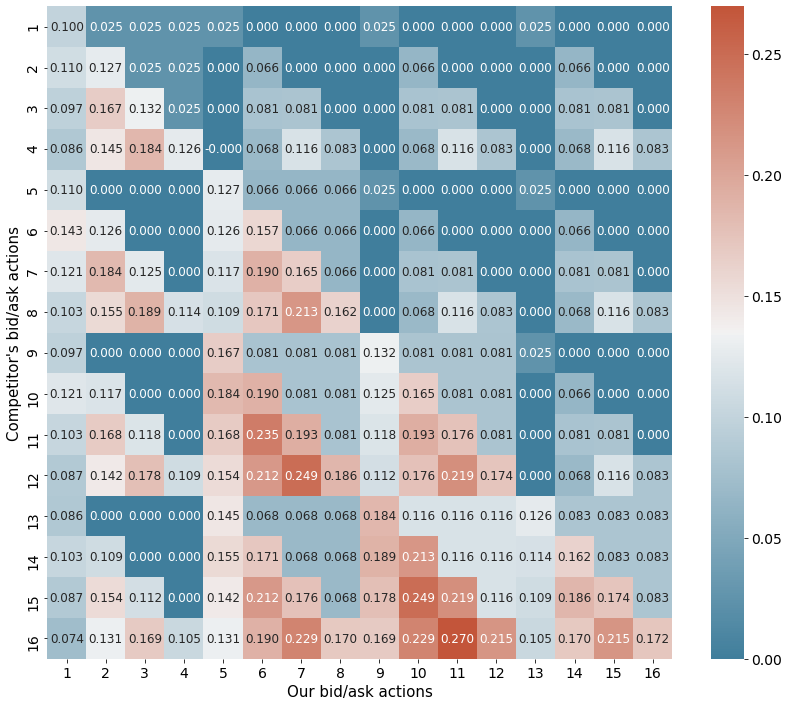

In [9]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(14, 12))
# labels = ['{:,.2f}'.format(x) for x in space]
labels = np.arange(tick_num**2) + 1
ax = sns.heatmap(R.transpose(), xticklabels=labels, yticklabels=labels, annot=True, fmt=".3f", 
                 annot_kws={"fontsize":12}, cmap=cmap)

ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.xlabel('Our bid/ask actions', fontsize=15)
plt.ylabel('Competitor\'s bid/ask actions', fontsize=15)
cbar = ax.collections[0].colorbar
# here set the labelsize by 14
cbar.ax.tick_params(labelsize=14)
# cbar = ax.figure.colorbar(ax.collections[0])
plt.savefig('twosides.pdf', format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.1)
# plt.show()